In [2]:
import numpy as np 
from qiskit import QuantumCircuit 
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_cutting.instructions import Move 
from qiskit_addon_cutting import partition_problem, generate_cutting_experiments, reconstruct_expectation_values
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2, Batch 
from qiskit_aer.primitives import EstimatorV2

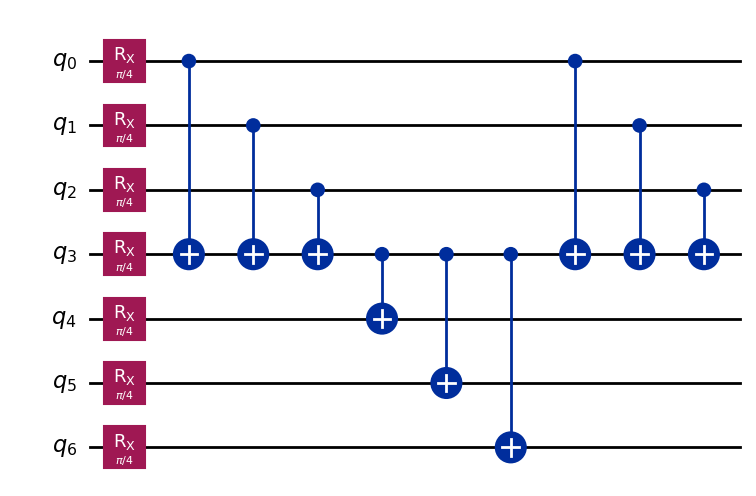

In [3]:
# Mapping the circuit 

qc_0 = QuantumCircuit(7)

for i in range(7):
    qc_0.rx(np.pi / 4, i)

qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

qc_0.draw("mpl")

In [16]:
# Specifying an observable

observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

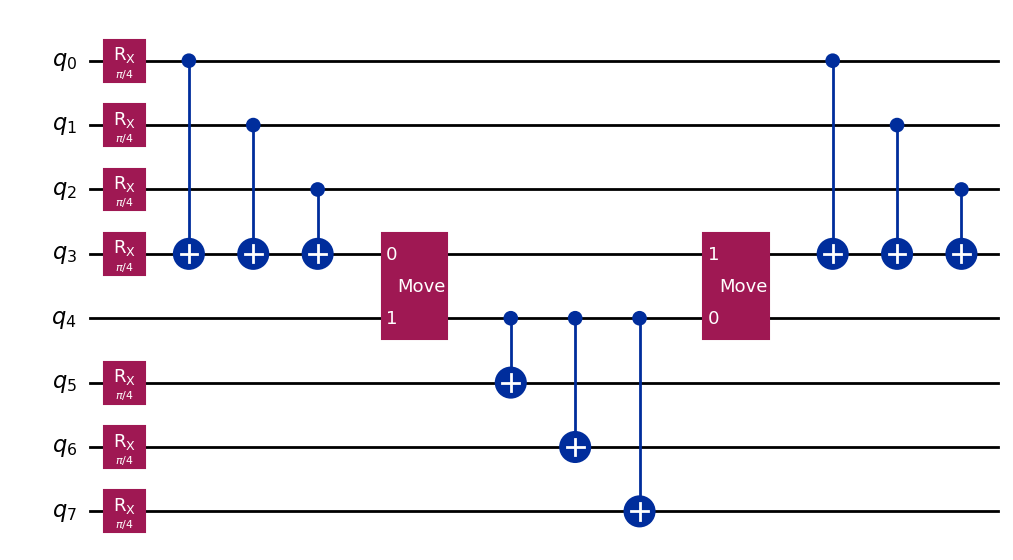

In [15]:
# Optimize 

qc_1 = QuantumCircuit(8)

for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)

qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

qc_1.draw("mpl")

In [17]:
# Specifying another observable 

observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

In [18]:
# Partitioning circuits and observables 

partitioned_problem = partition_problem(circuit=qc_1, partition_labels="AAAABBBB", observables=observable_expanded.paulis)
subcircuits = partitioned_problem.subcircuits 
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases 

# Visualize 
subobservables 

{'A': PauliList(['IIII', 'ZIII', 'IIIZ']),
 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

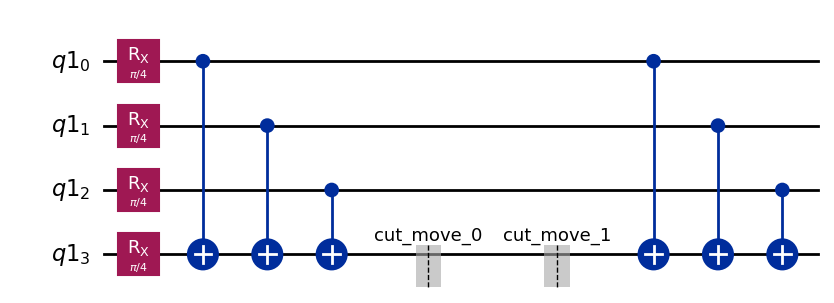

In [19]:
subcircuits["A"].draw('mpl')

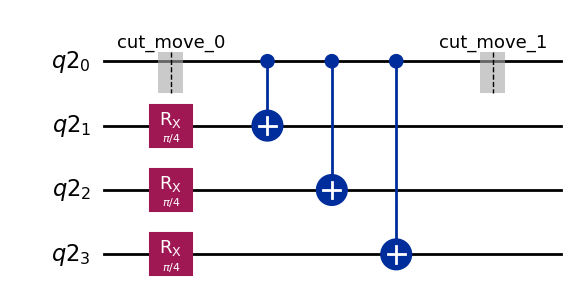

In [20]:
subcircuits["B"].draw("mpl")

In [21]:
# Calculating the sampling overhead for the chosen cuts 
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 256.0


In [22]:
# Generating subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(circuits=subcircuits, observables=subobservables, num_samples=np.inf)

# Choosing a backend 
backend = FakeManilaV2()

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {label: pass_manager.run(partition_subexpts) for label, partition_subexpts in subexperiments.items()}

# Submit each partition's subexperiments to the Qiskit Runtime Sampler primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {label: sampler.run(subsystem_subexpts, shots=2**12) for label, subsystem_subexpts in isa_subexperiments.items()}

# Results 
results = {label: job.result() for label, job in jobs.items()}

In [23]:
# Post-processing 

reconstructed_expval_terms = reconstruct_expectation_values(results, coefficients, subobservables,)
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

estimator = EstimatorV2()
exact_expval = estimator.run([(qc_0, observable)]).result()[0].data.evs

print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}")

Reconstructed expectation value: 1.51125312
Exact expectation value: 1.59099026
Error in estimation: -0.07973714
Relative error in estimation: -0.05011793
